## Биомедицинские нанотехнологии и компьютерное зрение (Computer Vision) 
<br>

### 4. Обнаружение и описание признаков на изображении

In [1]:
# Feature Detection and Description 
# https://docs.opencv.org/3.4/db/d27/tutorial_py_table_of_contents_feature2d.html

<div align='justify'>В данном модуле мы рассмотрим ещё один часто используемый метод описания изображений и его особенностей в области компьютерного зрения. Давайте представим себе ситуацию, когда вы анализируете изображение, которое видите вперые. Оно кажется вам малознакомым и, возможно, интересным. Возникает закономерный вопрос, почему наш хорошо обученный мозг считает данную инормацию новой? Вся проблема в том, что в данном случае для запоминания конкретного образа на изображение наш мозг должен проанализировать его и понять, если на нём особенности, которые ему знакомы. Кроме того, всё это будет восприниматься в совокупности тех элементов, которые представлены на изображении. Именно быстрый анализ этих особенностей и позволяет установить, знакомо ли вам даннаое изображение или нет. На рисунке ниже (а) прдставлен пример изображения здания. На нём выделены отдельные области: A, B, C, D, E, F. Все они являются особенностями. Что-то запоминается лучше, что хуже, но все эти части изображения могут послужить основой для запоминания изображения целиком. Если компазиция сложная, то подобных особенностей потребуется больше. Значительно проще анализировать простые компазиции. Например, изображение (б) зелёного прямоугольника с выделенными участками красного, синего и чёрного прямоугольников. Данное изображение анализировать, отслеживать изменение положения объектов и их ориентацию значительно проще, т.к. локальные особенности сразу же видны. Аналогично и описание особенностей объектов на изображении с помощью математических функций (Feature Description). Правильно описанная область объекта может быть использована для других задач. Вы можете найти одинаковые объекты на других изображениях, выровнять их или сшить вместе.</div>

<div align='center'>
<div style="float:left">
<p>(а)</p>
<img width='70%' src='img/feature_building.jpg'>
</div>
<div style="float:right">
<p>(б)</p>
<img width='90%' src='img/feature_simple.png'>
</div>
</div>

<div align='justify'>Далее мы рассмотрим основные методы выделения особенностей на изображении. Будут представлены примеры следующих методов: определение углов по методу Харриса, масштабно-инвариантная трансформация признаков, извлечение признаков по ускоренному анализу сегмента, компбинированный метод детектора ключевых точек и бинарных дескрипторов. В финале посмотрим, как комбинированный метод позволяет распознать объект на изображении. 
</div>

### 4.1 Определение углов по методу Харриса (Harris Corner Detection)

In [2]:
# Harris Corner Detection
# https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html

<div align='justify'> В методе Харриса поиск угла выполняется для некоторой локальной области. Возможно три варианта: область находится на краю, область находится вне фигуры и попадание в угол. Ниже представлена схема для поиска углов.<div>

<img width='70%' src='img/corners.png'>

<div align='justify'>Для описания смещения окна используют специальную функцию. На основе данной функции получают матрицу интенсивностей M по всем направлением. Анализ матрицы позволяет понять, находится ли объект в углу или нет. Важными параметрами являются λ1 и λ2 - собственные значения матрицы M. Величины этих собственных значений определяют, является ли область углом или нет. Область является углом, если значения λ1 и λ2 очень большие и приблизительно равны.<div>

<div align='justify'><b>Примечанеи</b>: подробнее об алгоритме Harris Corner Detection можно прочитать на сайте разработчика библиотеки OpenCV.</div>

#### Программа для определения углов по методу Харриса (Harris Corner Detection)

In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
 
# Загрузка и чтение изображения из заданной директории
img = cv.imread('img/red_blood_cell.jpg')
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_rgb_c = img_rgb.copy()

# Создание HCD объекта
hcd = cv.cornerHarris(img_gray, 2, 3, 0.04)

# Расширение результатов поиска углов
hcd = cv.dilate(hcd, None)

# Пороговое значение для изображения
# Может меняться для разных изображений
img_rgb_c[hcd>0.01*hcd.max()]=[0, 0, 255]

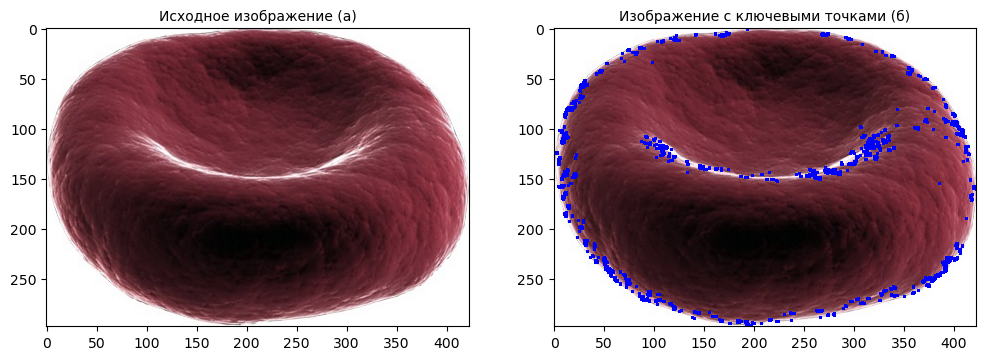

In [4]:
# Визуализация изображения
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.set_title('Исходное изображение (а)', size=10)
ax.imshow(img_rgb)
ax.axis('on')

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Изображение с ключевыми точками (б)', size=10)
ax.imshow(img_rgb_c)
ax.axis('on')

plt.show()

### 4.2 Масштабно-инвариантная трансформация признаков (SIFT)

In [5]:
# Scale-Invariant Feature Transform
# https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html

<div align='justify'>Если мы анализируем изображение, на котором достаточно хорошо видный границы и углы объектов, то и многие алгоритмы хорошо определяют данные углы. В этом случае мы используем стандартный размер окна. А если мы имеем дело с большими углами, для которых размер стандартного окна использовать нельзя, как поступают в этом случае? Для этого, например, можно использовать алгоритм масштабно-инвариантной трансформации признаков SIFT. Алгоритм состоит из двух этапов обработки изображения:<br>

1. Выделение ключевых точек (а). Алгоритм SIFT ищет точки с высокой контрастностью и локальной стабильностью, которые затем помечаются как ключевые. Для поиска используется рассчёт Лапласиана Гаусса для разных масштабов изображения, а точнее разность гауссианов, которая является аппроксимацией логарифма.
2. Описание ключевых точек (б). Для каждой ключевой точки создается дескриптор, описывающий ее локальное окружение. Такие дескрипторы сохраняют свою информативность при изменении масштаба или поворота объекта.

Отличительной чертой SIFT является то, что он использует гистограммы направленных градиентов (HOG) для описания ключевых точек. HOG определяет градиенты яркости вокруг каждой ключевой точки и создает гистограмму, которая показывает направления этих градиентов. Благодаря такому подходу можно описывать локальные характеристики изображения без учета их масштаба или ориентации.</div>

<div align='center'>
<div>
<p>(а)</p>
<img width='50%' src='img/sift_dog.jpg'>
</div>
<br>
<div>
<p>(б)</p>
<img width='55%' src='img/sift_gradient.png'>
</div>
</div>

<div align='justify'><b>Примечанеи</b>: подробнее об алгоритме SIFT можно прочитать на сайте разработчика библиотеки OpenCV.</div>

#### Программа масштабно-инвариантной трансформации признаков (SIFT)

In [6]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
 
# Загрузка и чтение изображения из заданной директории
img = cv.imread('img/red_blood_cell.jpg')
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Создание SIFT объекта
sift = cv.SIFT_create()

# Поиск и отрисовка ключевых точек по методу SIFT
key_points = sift.detect(img_gray, None)
img = cv.drawKeypoints(img_gray, key_points, img)

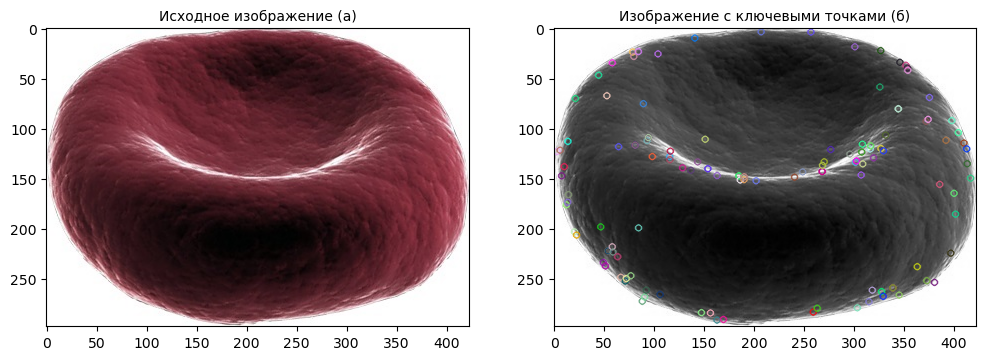

In [7]:
# Визуализация изображения
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.set_title('Исходное изображение (а)', size=10)
ax.imshow(img_rgb)
ax.axis('on')

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Изображение с ключевыми точками (б)', size=10)
ax.imshow(img)
ax.axis('on')

plt.show()

### 4.3 Извлечение признаков по ускоренному анализу сегмента (FAST)

In [8]:
# FAST Algorithm for Corner Detection 
# https://docs.opencv.org/3.4/d7/d00/tutorial_meanshift.html

<div align='justify'>Рассмотренные выше алгоритмы имеют определённые ограничения в использовании. В частности, если требуется быстрая обработка изображений, то их использование ограничего. В этом случае в качестве альтернативы может быть использован алогритм FAST (Features from Accelerated Segment Test), который позволяет решить проблему со скоростью обрабтки данных. В основе алгоритма лежит принцип разбиения изображения на блоки и проверка каждого блока на предмет наличия углов. Процесс работы алгоритма можно описать следующими шагами:<br>

1. Изображение разбивается на квадратные блоки заданного размера.
2. В каждом блоке производится поиск углов с использованием метода AST (Accelerated Segment Test). Выделение окружности из 16 пикселей, выделение центрального пикселя и анализ N смежных точек относительно центральной. 
3. При обнаружении угла он будет отмечен ключевой точкой. Для улучшения результатов детектирования достаточно часто используется метод Non-maximal Suppression. 

Алгоритм FAST может быть полезен в задачах, где требуется быстрое и точное определение характерных точек на изображениях.
</div>

<img width='60%' src='img/fast_speedtest.jpg'>

<div align='justify'><b>Примечанеи</b>: подробнее об алгоритме FAST можно прочитать на сайте разработчика библиотеки OpenCV.</div>

#### Программа для извлечения признаков по ускоренному анализу сегмента (FAST)

In [9]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# Загрузка и чтение изображения из заданной директории
img = cv.imread('img/red_blood_cell.jpg', cv.IMREAD_GRAYSCALE)

# Создание FAST объекта
fast = cv.FastFeatureDetector_create()

# Поиск и отрисовка ключевых точек по методу FAST
kp = fast.detect(img, None)
img_2 = cv.drawKeypoints(img, kp, None, color=(255,0,0))

# Поиск и отрисовка ключевых точек с удалением лишних рамок
fast.setNonmaxSuppression(0)
kp = fast.detect(img, None)
img_3 = cv.drawKeypoints(img, kp, None, color=(255,0,0))

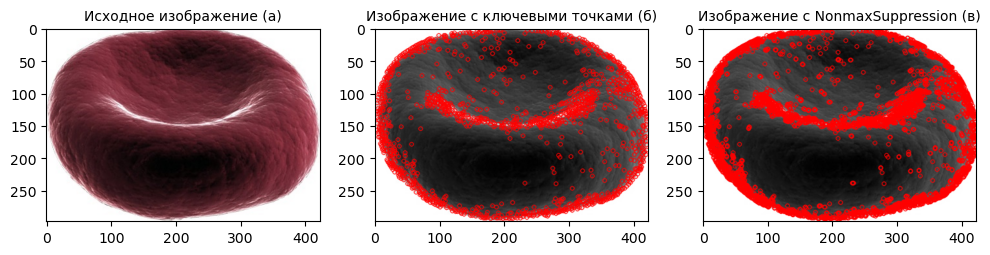

In [10]:
# Визуализация изображения
fig = plt.figure(figsize=(12, 3))

ax = fig.add_subplot(1, 3, 1)
ax.set_title('Исходное изображение (а)', size=10)
ax.imshow(img_rgb)
ax.axis('on')

ax = fig.add_subplot(1, 3, 2)
ax.set_title('Изображение с ключевыми точками (б)', size=10)
ax.imshow(img_2)
ax.axis('on')

ax = fig.add_subplot(1, 3, 3)
ax.set_title('Изображение с NonmaxSuppression (в)', size=10)
ax.imshow(img_3)
ax.axis('on')

plt.show()

### 4.4 Комбинация детектора ключевых точек FAST и бинарных дескрипторов BRIEF (ORB)

In [11]:
# Oriented FAST and Rotated BRIEF
# https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html

<div align='justify'>Ещё одним интересным и полезным методом для поиска признаков является метод ORB. Он основан на использовании других методах: детектор ключевых точек FAST и бинарных дескрипторов BRIEF. Далее будет представлен пример применения данного алгоритма.</div>

<div align='justify'><b>Примечанеи</b>: подробнее об алгоритме ORB можно прочитать на сайте разработчика библиотеки OpenCV.</div>

#### Программа для реализации метода Oriented FAST and Rotated BRIEF

In [12]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# Загрузка и чтение изображения из заданной директории
img = cv.imread('img/red_blood_cell.jpg', cv.IMREAD_GRAYSCALE)

# Создание ORB объекта
orb = cv.ORB_create()

# Поиск ключевых точек по методу ORB
kp = orb.detect(img, None)
kp, des = orb.compute(img, kp)

# Отрисовка ключевых точек
img2 = cv.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=0)

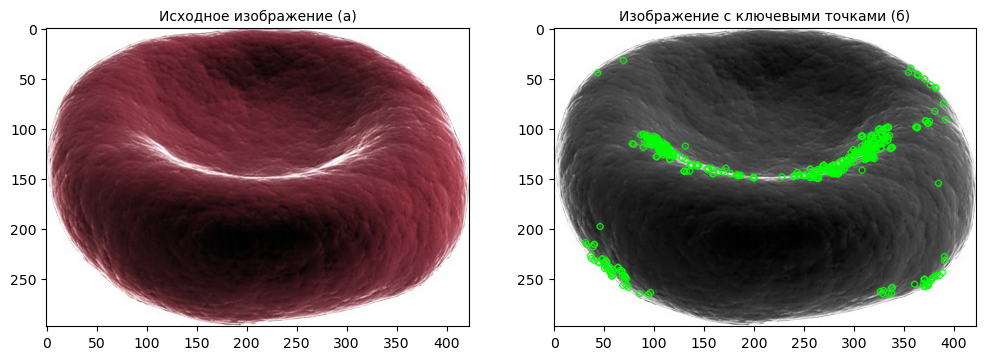

In [13]:
# Визуализация изображения
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.set_title('Исходное изображение (а)', size=10)
ax.imshow(img_rgb)
ax.axis('on')

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Изображение с ключевыми точками (б)', size=10)
ax.imshow(img2)
ax.axis('on')

plt.show()

### 4.5 Сопоставление объектов с использованием алгоритма ORB

<div align='justify'>Теперь мы дадим ответ на самый главный вопрос всего модуля. Для чего важно знать и как можно использовать знание об используемых признаках? Знание признаков, например, необходимо если мы хотим выполнить анализ определённых элементов на изображении. Выдлить данные объекты и определить их принадлежность к определённому классу объектов. По своей сути это очень близко к распознование образов и классификации объектов, которые очень часто используется в алгоритмах машинного обучения. Рассмотрим пример сопоставления объектов с использованием алгоритма ORB.</div>

In [14]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# Загрузка и чтение изображения из заданной директории
query_img = cv.imread('img/red_blood_cell_big.jpg')
train_img = cv.imread('img/red_blood_cell.jpg')

# Преобразование из BGR -> GRAY
query_img_gr = cv.cvtColor(query_img, cv.COLOR_BGR2GRAY)
train_img_gr = cv.cvtColor(train_img, cv.COLOR_BGR2GRAY)

# Создание ORB объекта
orb = cv.ORB_create()

# Поиск ключевых точек по методу ORB
queryKeypoints, queryDescriptors = orb.detectAndCompute(query_img_gr, None)
trainKeypoints, trainDescriptors = orb.detectAndCompute(train_img_gr, None)

# Создание объекта для сравнения данных
matcher = cv.BFMatcher()
matches = matcher.match(queryDescriptors,trainDescriptors)

# Отрисовка ключевых точек по шаблону
final_img = cv.drawMatches(query_img, queryKeypoints,
                           train_img, trainKeypoints, matches[:20], None) 

final_img = cv.resize(final_img, (1000, 650))
final_img = cv.cvtColor(final_img, cv.COLOR_BGR2RGB)

total_matches = len(matches)
 
# Вывод общего количества найденных совпадений объектов
print(f'Общее количество совпадений: {total_matches}')

Общее количество совпадений: 500


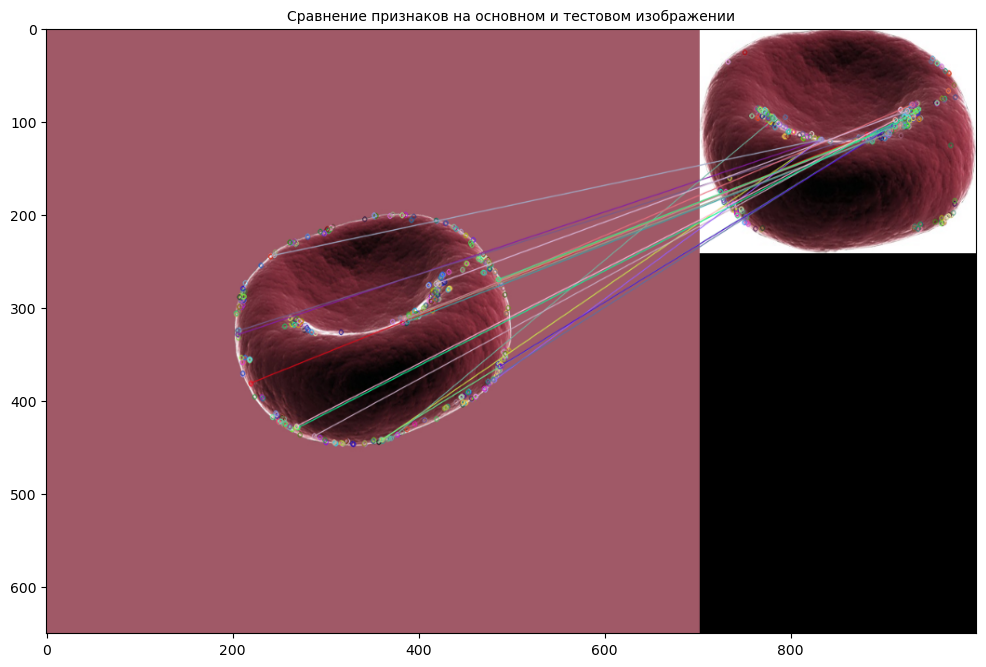

In [15]:
# Визуализация изображения
fig = plt.figure(figsize=(12, 10))

ax = fig.add_subplot(1, 1, 1)
ax.set_title('Сравнение признаков на основном и тестовом изображении', size=10)
ax.imshow(final_img)
ax.axis('on')

plt.show()

<div align='justify'>Количество найденных признаков свидетельствует о схожести сравниваемых изображений. Чем больше признаков найдено, тем больше вероятность того, что анализируемые объекты одинаковы. На основе данного подхода можно реализовать алгоритм классификации изображений.</div>

### Задание для самостоятельной работы.

1. Объясните, в чём заключается принцип определения углов по методу Харриса (Harris Corner Detection). Какой метод в библиотеке OpencV существует для реализации метода Харриса.

2. Объясните принцип нахождения признаков на изображении, который используется в основе метода масштабно-инвариантной трансформации (SIFT). Какой метод в библиотеке OpencV существуют для реализации SIFT.

3. Объясните принцип нахождения признаков объекта на основе извлечение признаков по ускоренному анализу сегмента (FAST). Какой метод в библиотеке OpencV существуют для реализации FAST.

4. В чём заключается особенность метода ORB. Какой метод в библиотеке OpencV существуют для реализации ORB.

5. Опишите порядок действий при сопоставлении объектов с использованием алгоритма ORB.

6. Практическая работа. Необходимо установить, к какому типу клеток относятся элементы на изображении (использовать изображения rand_cells_1.jpg, rand_cells_2.jpg и rand_cells_3.jpg). Для определения типа клеток необходимо использовать сопоставление объектов на основе метода ORB. В качестве изображения для сравнений используйте cell_1.png, cell_2.png и т.д. Будем считать наиболее близкими те объекты, количество общих признаков которых будет больше всего. Ложные срабатывания рекомендуется исключить.